In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
# Librerías para visualizacion
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import re
import networkx as nx
from itertools import count
from itertools import combinations
from itertools import product
import statsmodels.api as sm
import urllib.request, json
!pip3 install geopandas
import geopandas
# -- set scientific notation to display numbers fully rather than exponential
pd.set_option('display.float_format', '{:.2f}'.format)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' 
import seaborn as sns
sns.set_style('whitegrid') # grids en dark background

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth',300)
print('librerías cargadas')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 7.8 MB 44.0 MB/s 
     |████████████████████████████████| 16.6 MB 109 kB/s 
librerías cargadas


#¿Qué es PRODY?

This is a measure calculated as the GDP per
capita of countries that produce it, weighted by their revealed comparative advantage in
that product.

Se importa la base desde drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
## Se importa la base de exportaciones de productos drive
df = pd.read_csv("/content/drive/MyDrive/eci/base/df_updated.csv")
print('dataframe cargado')

dataframe cargado


In [4]:
df.sample(n=6)
df.info()

,year,country_code,country_name,product_code,product_name,export_value
2181134,2000,OMN,Oman,3101,"Fertilizers; animal or vegetable, whether or not mixed together or chemically treated; fertilizers produced by the mixing or chemical treatment of animal or vegetable products",232420
6660314,2005,KEN,Kenya,8711,"Motorcycles (including mopeds) and cycles; fitted with an auxiliary motor, with or without side-cars; side-cars",1013379
4829249,1998,RWA,Rwanda,7201,"Pig iron and spiegeleisen in pigs, blocks or other primary forms",146629
565630,2003,GNQ,Equatorial Guinea,1102,Cereal flours; other than of wheat or meslin,0
5782349,2015,COL,Colombia,8406,Turbines; steam and other vapour turbines,56989
610435,2018,UGA,Uganda,1109,Wheat gluten; whether or not dried,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7373271 entries, 0 to 7373270
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   year          int64 
 1   country_code  object
 2   country_name  object
 3   product_code  int64 
 4   product_name  object
 5   export_value  int64 
dtypes: int64(3), object(3)
memory usage: 337.5+ MB


In [91]:
df['country_name'].nunique()

242

#Calculo de RCA

In [5]:
## Función para el cálculo de RCA

def calc_rca(data,pais_col,prod_col,anio_col,value_col):
    """
      La función que calcula la RCA
    
    """
    print('Creando las combinaciones de país-producto-tiempo')
    df_all = pd.DataFrame(list(product(data[anio_col].unique(), data[pais_col].unique(),data[prod_col].unique())))
    df_all.columns=[anio_col,pais_col,prod_col]
    print('Se procede a fusionar los datos')
    df_all = pd.merge(df_all,data[[anio_col,pais_col,prod_col,value_col]],how='left',on=[anio_col,pais_col,prod_col])
    df_all.loc[df_all[value_col].isnull(),value_col] = 0

    # En esta parte se calculan propiedades
    print('calculando')
    df_all['Xcpt'] = df_all[value_col]
    df_all['Xct'] = df_all.groupby([pais_col, anio_col])[value_col].transform(sum)
    df_all['Xpt'] = df_all.groupby([prod_col, anio_col])[value_col].transform(sum)
    df_all['Xt'] = df_all.groupby([anio_col])[value_col].transform('sum')

    df_all['RCAcpt'] = (df_all['Xcpt']/df_all['Xct'])/(df_all['Xpt']/df_all['Xt']) #--> ecuación de las ventaja comparativa revelada RCA
    
    ## 0 si el producto / país tiene 0 exportaciones
    df_all.loc[df_all['RCAcpt'].isnull(),'RCAcpt'] = 0 
    # drop the properties 
    df_all.drop(['Xcpt','Xct','Xpt','Xt'],axis=1,inplace=True,errors='ignore')

    return df_all


In [6]:
df_rca = calc_rca(data=df,pais_col='country_name',prod_col='product_name',anio_col='year',value_col='export_value')

print('rca listo!!')

# Se muestran resultados
df_rca[0:10]

Creando las combinaciones de país-producto-tiempo
Se procede a fusionar los datos
calculando
rca listo!!


,year,country_name,product_name,export_value,RCAcpt
0,1995,Aruba,"Horses, asses, mules and hinnies; live",18008.00,0.13
1,1995,Aruba,Bovine animals; live,0.00,0.00
2,1995,Aruba,Swine; live,0.00,0.00
3,1995,Aruba,Sheep and goats; live,0.00,0.00
4,1995,Aruba,"Poultry; live, fowls of the species gallus domesticus, ducks, geese, turkeys and guinea fowls",0.00,0.00
5,1995,Aruba,"Animals, n.e.s. in chapter 01; live",2336.00,0.05
6,1995,Aruba,Meat of bovine animals; fresh or chilled,0.00,0.00
7,1995,Aruba,Meat of bovine animals; frozen,0.00,0.00
8,1995,Aruba,"Meat of swine; fresh, chilled or frozen",0.00,0.00
9,1995,Aruba,"Meat of sheep or goats; fresh, chilled or frozen",0.00,0.00


In [90]:
df_rca['country_name'].nunique()

242

###Se filtra el dataframe solo para Ecuador

In [7]:

# Ecuador
df_rca[ (df_rca['country_name']=='Ecuador')].sort_values(by=['RCAcpt'],ascending=False)[['product_name','RCAcpt','year']][0:10]


,product_name,RCAcpt,year
2176048,"Bananas, including plantains; fresh or dried",266.11,2002
2476612,"Bananas, including plantains; fresh or dried",245.41,2003
1875484,"Bananas, including plantains; fresh or dried",244.05,2001
1574920,"Bananas, including plantains; fresh or dried",241.97,2000
1274356,"Bananas, including plantains; fresh or dried",234.63,1999
6384612,"Hat-shapes; plaited or made by assembling strips of any material, neither blocked to shape, nor with made brims, nor lined, nor trimmed",233.22,2016
6383944,"Bananas, including plantains; fresh or dried",231.67,2016
673228,"Bananas, including plantains; fresh or dried",229.02,1997
6684508,"Bananas, including plantains; fresh or dried",227.59,2017
6985072,"Bananas, including plantains; fresh or dried",225.52,2018


In [14]:
## Se importa la base de gdp percapita de todos los países desde el drive
df_gdppc_countries = pd.read_csv("/content/drive/MyDrive/eci/base/gpd_per_capita_countries_db.csv").copy()
print('dataframe del gpd cargado')

dataframe del gpd cargado


In [15]:
df_gdppc_countries[0:3]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6283.00,7567.25,9274.51,10767.40,11638.73,12850.22,13657.67,14970.15,16675.28,17140.43,17375.23,18713.43,19742.32,19833.83,21023.16,20913.30,21377.10,22050.83,24104.65,24975.67,25833.45,27665.43,29011.56,25739.14,24452.93,26044.44,25609.96,26515.68,26942.31,28421.39,28451.27,29326.71,30220.59,31650.76,24487.86,29342.10
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,162.91,162.55,172.00,199.18,179.38,198.22,209.41,211.70,224.23,249.58,260.11,278.75,293.08,370.41,444.72,459.90,444.08,489.85,530.37,600.37,738.87,732.92,681.65,691.99,615.41,508.69,552.54,654.32,697.22,722.43,817.15,858.30,728.77,704.74,697.18,762.84,739.47,757.85,696.37,669.69,706.99,628.20,626.56,812.95,985.53,1120.45,1226.18,1369.81,1428.33,1411.58,1643.55,1792.85,1760.22,1731.80,1719.81,1540.85,1432.11,1613.79,1550.18,1500.23,1353.77,1537.34
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,62.37,62.44,60.95,82.02,85.51,105.24,143.10,167.17,134.01,134.25,162.64,166.22,141.37,149.74,181.60,194.67,205.67,232.78,255.05,284.76,291.65,311.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,183.53,200.46,221.66,255.06,274.00,375.08,387.85,443.85,554.60,621.91,663.14,651.99,628.15,592.48,520.25,530.15,502.06,500.52,516.87,368.75


In [167]:
## Se modifica la base de gdp per capita con los datos que solo nos interesan
df_gdppc = df_gdppc_countries.filter(items=['Country Name','Country Code','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']).copy()
df_gdppc=df_gdppc.rename(columns={"Country Name": "country_name", "Country Code": "country_code"}).copy()
df_gdppc=df_gdppc.melt(id_vars=["country_name", "country_code"], 
        var_name="year", 
        value_name="Value").copy()
df_gdppc=df_gdppc.rename(columns={"Value": "gpd_per_capita"}).copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Latin America & the Caribbean (IDA & IBRD countries)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (excluding high income)' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'World' ].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Fragile and conflict affected situations'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Pacific island small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'OECD members'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Caribbean small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Heavily indebted poor countries (HIPC)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Small states'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'East Asia & Pacific (excluding high income)'].copy()
df_gdppc =  df_gdppc.loc[df_gdppc["country_name"] != 'Europe & Central Asia (IDA & IBRD countries)'].copy()
df_gdppc =  df_gdppc.loc[(df_gdppc["country_name"] != 'Lower middle income') & (df_gdppc["country_name"] != 'IBRD only')& (df_gdppc["country_name"] != 'IDA total') & (df_gdppc["country_name"] != 'East Asia & Pacific')
&(df_gdppc['country_name']!='Sub-Saharan Africa (excluding high income)')&(df_gdppc['country_name']!='Low & middle income')&(df_gdppc['country_name']!='Not classified')
&(df_gdppc['country_name']!='Middle East & North Africa (IDA & IBRD countries)')&(df_gdppc['country_name']!='Post-demographic dividend')&(df_gdppc['country_name']!='Latin America & Caribbean')
&(df_gdppc['country_name']!='Middle income')&(df_gdppc['country_name']!='East Asia & Pacific (IDA & IBRD countries)')&(df_gdppc['country_name']!='IDA & IBRD total') 
&(df_gdppc['country_name']!='Least developed countries: UN classification')].copy()
	



# df_gdppc = df_gdppc.drop(df_gdppc.index[3254]).copy()
# df_gdppc = df_gdppc.drop(df_gdppc.index[3522]).copy() #Europe & Central Asia (excluding high income)
# df_gdppc = df_gdppc.drop(df_gdppc.index[1162]).copy() #Heavily indebted poor countries (HIPC)	
# df_gdppc = df_gdppc.drop(df_gdppc.index[[3960,3965,134,4703,1579,5193,2092,2454,449,3407,1395,1204,191,4143,1394,3993,3096,1527,3254,3522,1162,3428,4132,4454]]).copy() #Heavily indebted poor countries (HIPC),	Latin America & the Caribbean (IDA & IBRD countries)	
df_gdppc["year"]=df_gdppc["year"].astype(np.int64).copy()



df_gdppc.sample(n=10)
df_gdppc.shape
df_gdppc.info()
#World
#Fragile and conflict affected situations
#East Asia & Pacific (excluding high income)
#Pacific island small states

,country_name,country_code,year,gpd_per_capita
4899,Ireland,IRL,2018,79250.39
5099,Colombia,COL,2019,6438.06
1934,Ethiopia,ETH,2007,240.35
1410,Gabon,GAB,2005,6570.96
2680,Bangladesh,BGD,2010,776.86
3212,Bangladesh,BGD,2012,876.82
3434,Trinidad and Tobago,TTO,2012,18961.23
8,United Arab Emirates,ARE,2000,31855.50
3629,Namibia,NAM,2013,5463.02
4912,Kiribati,KIR,2018,1605.01


(4820, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4820 entries, 0 to 5319
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    4820 non-null   object 
 1   country_code    4820 non-null   object 
 2   year            4820 non-null   int64  
 3   gpd_per_capita  4632 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 188.3+ KB


In [168]:
df_gdppc['country_name'].nunique()

241

In [171]:
# se hace un merge entre la base de gdp por países y el dataframe de RCA
df_merge = df_rca.merge(df_gdppc, how='inner', on=['year','country_name']).copy()

df_merge.sample(n=10)
df_merge.shape

df_merge.info()

,year,country_name,product_name,export_value,RCAcpt,country_code,gpd_per_capita
437877,2001,Guam,"Garments made up of knitted or crocheted fabrics of heading no. 5903, 5906 and 5907",0.00,0.00,GUM,NaN
4107398,2018,Guatemala,"Ground-nuts; not roasted or otherwise cooked, whether or not shelled or broken",3729.00,0.00,GTM,4485.73
458378,2002,Australia,Vanilla,280420.00,0.10,AUS,20291.18
1581621,2007,Belgium,Wallpaper and similar wall coverings; window transparencies of paper,96441568.00,2.08,BEL,44319.17
2112936,2009,Jordan,Chlorides; chloride oxides and chloride hydroxides; bromides and bromide oxides; iodides and iodide oxides,24775850.00,29.98,JOR,3618.89
3192697,2014,Estonia,"Friction material and articles thereof (eg sheets, rolls, strips, segments, discs, washers, pads) not mounted; for brakes, clutches, with a basis of asbestos, other mineral substances, or cellulose",240600.00,0.17,EST,20261.07
243957,2001,Bangladesh,"Builders' joinery and carpentry of wood, including cellular wood panels, assembled parquet panels, shingles and shakes",976.00,0.00,BGD,410.05
1342262,2006,Aruba,"Aluminium; tube or pipe fittings (eg couplings, elbows, sleeves)",0.00,0.00,ABW,25833.45
631245,2002,Turks and Caicos Islands,"Salts of inorganic acids or peroxoacids, excluding azides, n.e.s.",0.00,0.00,TCA,17803.08
3972851,2017,Solomon Islands,"Bismuth; articles thereof, including waste and scrap",0.00,0.00,SLB,2283.58


(4471200, 7)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4471200 entries, 0 to 4471199
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   year            int64  
 1   country_name    object 
 2   product_name    object 
 3   export_value    float64
 4   RCAcpt          float64
 5   country_code    object 
 6   gpd_per_capita  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 272.9+ MB


In [88]:
df_merge['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [170]:
df_merge['country_name'].nunique()


180

Se crea el objeto de valores de gpd per capita de los últimos 20 años

In [10]:
gdp_per_capita_ec = [{'year':2000, 'gdp_per_capita': '1445.3'}, 
                     {'year': 2001, 'gdp_per_capita': '1894.6'},
                     {'year': 2002, 'gdp_per_capita' : '2172.1' },
                      {'year': 2003, 'gdp_per_capita': '2425.9'},
                      {'year': 2004, 'gdp_per_capita': '2691.3'},
                     {'year': 2005, 'gdp_per_capita': '3002.1'},
                      {'year': 2006, 'gdp_per_capita': '3328.9'},
                        {'year': 2007, 'gdp_per_capita': '3567.8'},
                        {'year': 2008, 'gdp_per_capita': '4249'},
                         {'year': 2009, 'gdp_per_capita': '4231.6'},
                         {'year': 2010, 'gdp_per_capita': '4633.6'},
                         {'year': 2011, 'gdp_per_capita': '5200.6'},
                         {'year': 2012, 'gdp_per_capita': '5682'},
                         {'year': 2013, 'gdp_per_capita': '6056.3'},
                         {'year': 2014, 'gdp_per_capita': '6377.1'},
                         {'year': 2015, 'gdp_per_capita': '6124.5'},
                          {'year': 2016, 'gdp_per_capita': '6060.1'},
                          {'year': 2017, 'gdp_per_capita': '6213.5'},
                          {'year': 2018, 'gdp_per_capita': '6295.9'},
                          {'year': 2019, 'gdp_per_capita': '6222.5'},
                     ]

            
df_gdp_ec = pd.DataFrame(gdp_per_capita_ec)
# help(gdp_per_capita_ec)


In [11]:
df_gdp_ec[0:10]


,year,gdp_per_capita
0,2000,1445.3
1,2001,1894.6
2,2002,2172.1
3,2003,2425.9
4,2004,2691.3
5,2005,3002.1
6,2006,3328.9
7,2007,3567.8
8,2008,4249
9,2009,4231.6


The authors measure this sophistication indirectly by examining the wages of countries
who are intensive exporters of each product. First, they measure the sophistication of each
product, which they call PRODY, which is the revealed comparative advantage (RCA)-weighted
GDP per capita of each country that exports the good:



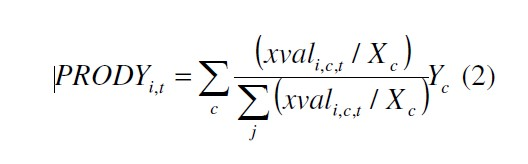